# Linear Bivariate BMM with SAMBA toy models : switchcos mixing

The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook [here.](https://mybinder.org/v2/gh/danOSU/Taweret/c2d8fd3ce3d74a5891d51adb5afc0afa0b503127?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FLinear_BMM_with_switchcos_function_for_SAMBA_models.ipynb)


This notebook try to reproduce the work by **A. C. Semposki, R. J. Furnstahl, D. R. Phillips** in  [Uncertainties here, there, and everywhere: interpolating between small- and large-g expansions using Bayesian Model Mixing](https://arxiv.org/abs/2206.04116) using the Bayesian model mixing package **Taweret**. 

**Author : Dan Liyanage**

Date : 11/10/2022

More about SAMBA toy models can be found in [Uncertainties here, there, and everywhere: interpolating between small- and large-g expansions using Bayesian Model Mixing](https://arxiv.org/abs/2206.04116)



**Steps for Bayesian Model Mixing with Taweret**

    1. Define your models using BayesModel class in `Taweret.core.bayesmodel` (Only if you want to bring in your own models)
    2. Choose a Mixing method (Avilable mixing methods can be found in Taweret/mix)
    3. Find the posterior for the mixture weights (parameters in the mixture function) and/or model parameters by training the mixed model. 
    4. Make predictions! 

In [2]:
import sys

# You will have to change the following imports depending on where you have 
# the packages installed
# If using binder please uncomment the followings.
sys.path.append("/home/jovyan/")
sys.path.append("/home/jovyan/subpackages/SAMBA")

#sys.path.append("/Users/dananjayaliyanage/git/Taweret")
#sys.path.append("/Users/dananjayaliyanage/git/Taweret/subpackages/SAMBA")

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
import bilby

# For other operations
import numpy as np

## 1. Get toy models and the pseudo-experimental data

In [4]:
# Toy models from SAMBA
from Taweret.models import samba_models as toy_models

m1 = toy_models.loworder(2, 'uninformative')
m2 = toy_models.highorder(2, 'uninformative')
truth = toy_models.true_model()
exp = toy_models.exp_data()

In [5]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.evaluate(plot_g)
m2_prediction = m2.evaluate(plot_g)
true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g,error = 0.01)

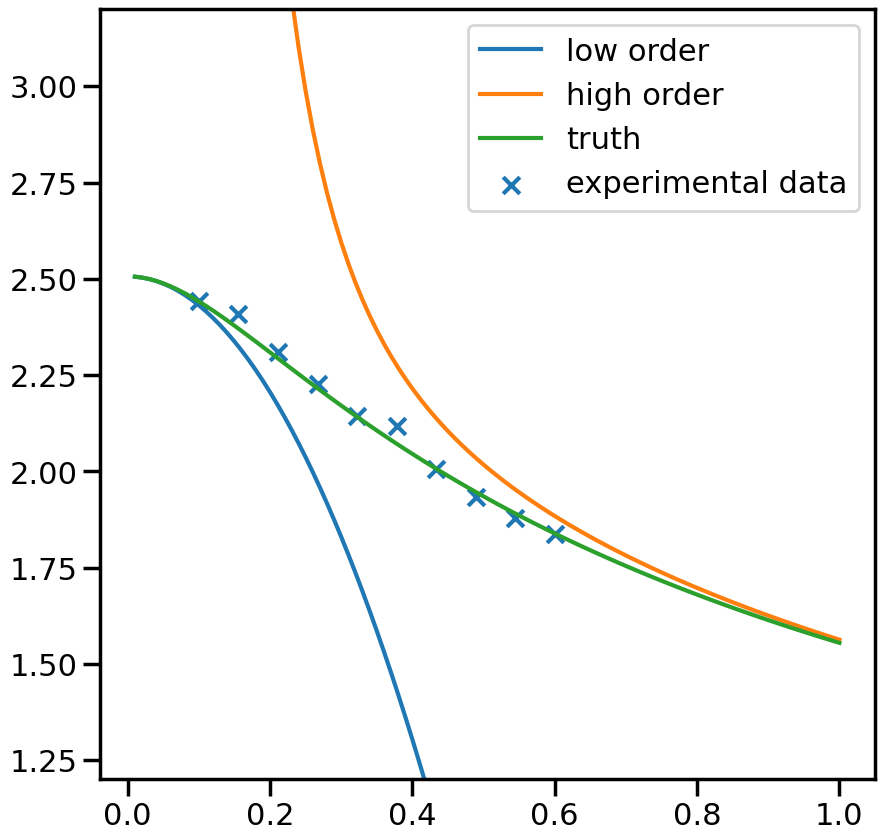

In [6]:

fig, ax_f = plt.subplots(figsize=(10,10))
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g,exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

###  2. Choose a Mixing method

In [7]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'low_order':m1,'high_order':m2}
mix_model = BL(models_dic=models, method='switchcos') 

switchcos mixing function has 3 free parameter(s)
To change the prior use `set_prior` method


#####  Need to speceify a constained prior for switchcos. g1 < g3 < g2
We follow Bilby documentation on how to specefy a prior with constraints
https://lscsoft.docs.ligo.org/bilby/prior.html#prior-constraints

In [8]:
# from scipy import stats 

# def luniform(theta, a, b):

#     if theta > a and theta < b:
#         return 0.0
#     else:
#         return -np.inf

# def lpdf(params):
#     if len(params) == 3:
#         #g1 truncated between (0, 0.35) 
#         g1 = luniform(params[0], 0.01, 0.3) + stats.norm.logpdf(params[0], 0.1, 0.05)   #0.1 for 2 v 2, #0.1 for 5 v 5
#         #g3 truncated between (g1, 0.35)
#         g3 = luniform(params[2], params[0], 0.55) + stats.norm.logpdf(params[2], 0.4, 0.05)   #0.4 for 2 v 2, #0.25 for 5 v 5
#         #g2 truncated between (g3, 0.35)
#         g2 = luniform(params[1], params[2], 0.8) + stats.norm.logpdf(params[1], 0.6, 0.05)  #0.6 for 2 v 2, #0.4 for 5 v 5
#         return (g1 + g2 + g3)
#     else:
#         print(params)
#         raise ValueError('The number of parameters does not match any available switching function.')

In [9]:
from bilby.core.prior.joint import BaseJointPriorDist, JointPrior, JointPriorDistError
from samba.priors import Priors as samba_P
samba_prior = samba_P()


class custom_prior_switchcos(BaseJointPriorDist):
    def __init__(self, names, bounds=None):
        '''
        A class defining prior for swithcos mixing method

        Parameters
        ==========
        names: list
            A list of the parameter names in the prior
        '''
        super().__init__(names=names, bounds=bounds)
        self.names=names
    def ln_prob(self,value):
        try:
            n_sam = value.shape[1]
            return [samba_prior.lpdf(x) for x in value]
        except:
            return samba_prior.lpdf(value)

    def _sample(self, size, **kwargs):
        """
        Draw, and set, a sample for the switchcos parameter joint distribution

        Parameters
        ==========
        size: int
            number of samples to generate, defaults to 1
        """
        samps = np.zeros((size, len(self)))
        samps[:,0] = np.random.uniform(0.12, 0.18, size)
        samps[:,2] = np.random.uniform(0.19, 0.24, size)
        samps[:,1] = np.random.uniform(0.25, 0.30, size)

        return samps

class prior_switchcos(JointPrior):
    def __init__(self, dist, name=None, latex_label=None, unit=None):
        if not isinstance(dist, custom_prior_switchcos):
            raise JointPriorDistError("dist object must be instance of custom_prior_switchcos")
        super().__init__(dist=dist, name=name, latex_label=latex_label, unit=unit)

mvg = custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds=[[0.0,0.35],[0.0,0.35],[0.0,0.35]])
priors = bilby.core.prior.PriorDict()
priors['switchcos_0'] = prior_switchcos(mvg,'switchcos_0')
priors['switchcos_1'] = prior_switchcos(mvg,'switchcos_1')
priors['switchcos_2'] = prior_switchcos(mvg,'switchcos_2')


In [10]:
mix_model.set_prior(priors)

{'switchcos_0': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_0', latex_label='switchcos_0', unit=None),
 'switchcos_1': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_1', latex_label='switchcos_1', unit=None),
 'switchcos_2': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_2', latex_label='switchcos_2', unit=None)}

### 3. Train to find posterior

In [11]:
mix_model.prior

{'switchcos_0': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_0', latex_label='switchcos_0', unit=None),
 'switchcos_1': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_1', latex_label='switchcos_1', unit=None),
 'switchcos_2': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_2', latex_label='switchcos_2', unit=None)}

In [12]:
result = mix_model.train(x_exp=g, y_exp=exp_data[0], y_err=exp_data[1],outdir = 'outdir/samba_bivariate', label='switchcos_mix')

10:40 bilby INFO    : Running for label 'switchcos_mix', output will be saved to 'outdir/samba_bivariate'
10:40 bilby INFO    : Search parameters:
10:40 bilby INFO    :   switchcos_0 = __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_0', latex_label='switchcos_0', unit=None)
10:40 bilby INFO    :   switchcos_1 = __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_1', latex_label='switchcos_1', unit=None)
10:40 bilby INFO    :   switchcos_2 = __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_2', lat

The following Default settings for sampler will be used. You can changethese arguments by providing kwargs_for_sampler argement in `train`.Check Bilby documentation for other sampling options.
{'sampler': 'ptemcee', 'ntemps': 5, 'nwalkers': 20, 'Tmax': 100, 'burn_in_fixed_discard': 200, 'nsamples': 5000, 'threads': 6, 'printdt': 60}


10:40 bilby INFO    : Generating pos0 samples
10:40 bilby INFO    : Starting to sample


1|0:00:00|nc:5.0e+02|a0:0.40-1.00|swp:0.87-1.00|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.39ms/ev
2|0:00:00|nc:1.0e+03|a0:0.40-0.90|swp:0.83-0.98|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.35ms/ev
3|0:00:00|nc:1.5e+03|a0:0.40-0.87|swp:0.80-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.33ms/ev
4|0:00:00|nc:2.0e+03|a0:0.35-0.80|swp:0.78-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.30ms/ev
5|0:00:00|nc:2.5e+03|a0:0.32-0.80|swp:0.77-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.29ms/ev
6|0:00:00|nc:3.0e+03|a0:0.37-0.73|swp:0.79-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.29ms/ev
7|0:00:01|nc:3.5e+03|a0:0.37-0.77|swp:0.79-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.29ms/ev
8|0:00:01|nc:4.0e+03|a0:0.45-0.75|swp:0.80-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.30ms/ev
9|0:00:01|nc:4.5e+03|a0:0.44-0.76|swp:0.80-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.30ms/ev
10|0:00:01|nc:5.0e+03|a0:0.44-0.76|swp:0.80-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.32ms/ev
11|0:00:01|nc:5.5e+03|a0:0.45-0.73|swp:0.81-0.99|n:nan<5000|t!nan(+nan,+nan)|q:

90|0:00:16|nc:4.5e+04|a0:0.58-0.67|swp:0.85-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.40ms/ev
91|0:00:16|nc:4.6e+04|a0:0.58-0.67|swp:0.85-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.58ms/ev
92|0:00:16|nc:4.6e+04|a0:0.58-0.67|swp:0.85-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.61ms/ev
93|0:00:17|nc:4.6e+04|a0:0.59-0.66|swp:0.85-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.61ms/ev
94|0:00:17|nc:4.7e+04|a0:0.59-0.67|swp:0.85-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.43ms/ev
95|0:00:17|nc:4.8e+04|a0:0.59-0.67|swp:0.85-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.40ms/ev
96|0:00:17|nc:4.8e+04|a0:0.60-0.67|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.36ms/ev
97|0:00:17|nc:4.8e+04|a0:0.60-0.67|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.34ms/ev
98|0:00:17|nc:4.9e+04|a0:0.60-0.67|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.33ms/ev
99|0:00:18|nc:5.0e+04|a0:0.60-0.67|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.33ms/ev
100|0:00:18|nc:5.0e+04|a0:0.60-0.67|swp:0.86-0.99|n:nan<5000|t!nan(+na

178|0:00:32|nc:8.9e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.42ms/ev
179|0:00:32|nc:9.0e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.38ms/ev
180|0:00:32|nc:9.0e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.36ms/ev
181|0:00:33|nc:9.0e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.34ms/ev
182|0:00:33|nc:9.1e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.36ms/ev
183|0:00:33|nc:9.2e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.35ms/ev
184|0:00:33|nc:9.2e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.36ms/ev
185|0:00:33|nc:9.2e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.35ms/ev
186|0:00:33|nc:9.3e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.35ms/ev
187|0:00:34|nc:9.4e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.34ms/ev
188|0:00:34|nc:9.4e+04|a0:0.60-0.66|swp:0.86-0.99|n:nan<5000

265|0:00:48|nc:1.3e+05|a0:0.61-0.65|swp:0.86-0.99|n:20<5000|t!1(+nan,+0.08)|q:1.01|0.38ms/ev
266|0:00:48|nc:1.3e+05|a0:0.61-0.65|swp:0.86-0.99|n:-960<5000|t!2(+nan,+0.08)|q:1.01|0.40ms/ev
267|0:00:48|nc:1.3e+05|a0:0.61-0.65|swp:0.86-0.99|n:-940<5000|t!2(+nan,+0.08)|q:1.01|0.39ms/ev
268|0:00:49|nc:1.3e+05|a0:0.61-0.65|swp:0.86-0.99|n:80<5000|t!1(+nan,+0.07)|q:1.01|0.37ms/ev
269|0:00:49|nc:1.3e+05|a0:0.61-0.65|swp:0.86-0.99|n:-900<5000|t!2(+nan,+0.07)|q:1.01|0.34ms/ev
270|0:00:49|nc:1.4e+05|a0:0.61-0.65|swp:0.86-0.99|n:-880<5000|t!2(+nan,+0.07)|q:1.01|0.33ms/ev
271|0:00:49|nc:1.4e+05|a0:0.61-0.65|swp:0.86-0.99|n:-860<5000|t!2(+nan,+0.08)|q:1.00|0.32ms/ev
272|0:00:49|nc:1.4e+05|a0:0.61-0.65|swp:0.86-0.99|n:-840<5000|t!2(+nan,+0.09)|q:1.00|0.32ms/ev
273|0:00:49|nc:1.4e+05|a0:0.61-0.65|swp:0.86-0.99|n:-820<5000|t!2(+nan,+0.09)|q:1.00|0.34ms/ev
274|0:00:50|nc:1.4e+05|a0:0.61-0.65|swp:0.86-0.99|n:-800<5000|t!2(+nan,+0.09)|q:1.00|0.34ms/ev
275|0:00:50|nc:1.4e+05|a0:0.61-0.65|swp:0.86-0.99|n:-7

352|0:01:04|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.32ms/ev
353|0:01:04|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.33ms/ev
354|0:01:04|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-580<5000|t!1(+nan,+0.07)|q:1.03|0.33ms/ev
355|0:01:04|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-560<5000|t!1(+nan,+0.08)|q:1.03|0.34ms/ev
356|0:01:04|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-540<5000|t!1(+nan,+0.07)|q:1.04|0.33ms/ev
357|0:01:04|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-520<5000|t!1(+nan,+0.05)|q:1.03|0.33ms/ev
358|0:01:05|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-500<5000|t!1(+nan,+0.07)|q:1.03|0.33ms/ev
359|0:01:05|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-480<5000|t!1(+nan,+0.07)|q:1.02|0.33ms/ev
360|0:01:05|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-460<5000|t!1(+nan,+0.09)|q:1.02|0.34ms/ev
361|0:01:05|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:-440<5000|t!1(+nan,+0.06)|q:1.02|0.33ms/ev
362|0:01:05|nc:1.8e+05|a0:0.61-0.65|swp:0.86-0.99|n:

438|0:01:19|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:100<5000|t=2(+0.02,+0.05)|q:1.00|0.38ms/ev
439|0:01:19|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:120<5000|t=2(+0.02,+0.06)|q:1.00|0.37ms/ev
440|0:01:19|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:140<5000|t=2(+0.02,+0.03)|q:1.00|0.39ms/ev
441|0:01:19|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:160<5000|t=2(+0.02,+0.05)|q:1.00|0.37ms/ev
442|0:01:20|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:180<5000|t=2(+0.02,+0.06)|q:1.00|0.40ms/ev
443|0:01:20|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:200<5000|t=2(+0.02,+0.06)|q:1.00|0.37ms/ev
444|0:01:20|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:220<5000|t=2(+0.03,+0.05)|q:1.00|0.36ms/ev
445|0:01:20|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:240<5000|t=2(+0.02,+0.03)|q:1.00|0.33ms/ev
446|0:01:20|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:260<5000|t=2(+0.02,+0.04)|q:1.00|0.33ms/ev
447|0:01:20|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|n:280<5000|t=2(+0.04,+0.06)|q:1.00|0.33ms/ev
448|0:01:21|nc:2.2e+05|a0:0.61-0.65|swp:0.86-0.99|

524|0:01:34|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1820<5000|t=2(+0.01,+0.07)|q:1.00|0.42ms/ev
525|0:01:34|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1840<5000|t=2(+0.01,+0.05)|q:1.00|0.42ms/ev
526|0:01:35|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1860<5000|t=2(+0.01,+0.04)|q:1.00|0.40ms/ev
527|0:01:35|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1880<5000|t=2(+0.00,+0.05)|q:1.00|0.41ms/ev
528|0:01:35|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1900<5000|t=2(+0.00,+0.07)|q:1.00|0.41ms/ev
529|0:01:35|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1920<5000|t=2(+0.01,+0.05)|q:1.00|0.41ms/ev
530|0:01:35|nc:2.6e+05|a0:0.61-0.65|swp:0.86-0.99|n:1940<5000|t=2(+0.01,+0.04)|q:1.00|0.37ms/ev
531|0:01:36|nc:2.7e+05|a0:0.61-0.65|swp:0.86-0.99|n:1960<5000|t=2(+0.01,+0.03)|q:1.00|0.37ms/ev
532|0:01:36|nc:2.7e+05|a0:0.61-0.65|swp:0.86-0.99|n:1980<5000|t=2(+0.01,+0.04)|q:1.00|0.37ms/ev
533|0:01:36|nc:2.7e+05|a0:0.61-0.65|swp:0.86-0.99|n:2000<5000|t=2(+0.01,+0.03)|q:1.00|0.38ms/ev
534|0:01:36|nc:2.7e+05|a0:0.61-0.65|swp:

610|0:01:49|nc:3.0e+05|a0:0.61-0.65|swp:0.86-0.99|n:-1020<5000|t!2(+nan,+0.07)|q:1.00|0.37ms/ev
611|0:01:50|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-1000<5000|t!2(+nan,+0.05)|q:1.00|0.37ms/ev
612|0:01:50|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-980<5000|t!2(+nan,+0.07)|q:1.00|0.33ms/ev
613|0:01:50|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-960<5000|t!2(+nan,+0.07)|q:1.00|0.32ms/ev
614|0:01:50|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-940<5000|t!2(+nan,+0.05)|q:1.00|0.34ms/ev
615|0:01:50|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-920<5000|t!2(+nan,+0.05)|q:1.00|0.33ms/ev
616|0:01:50|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-900<5000|t!2(+nan,+0.04)|q:1.00|0.33ms/ev
617|0:01:51|nc:3.1e+05|a0:0.61-0.65|swp:0.86-0.99|n:-880<5000|t!2(+nan,+0.06)|q:1.00|0.34ms/ev
618|0:01:51|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-860<5000|t!2(+nan,+0.07)|q:1.00|0.36ms/ev
619|0:01:51|nc:3.1e+05|a0:0.61-0.64|swp:0.86-0.99|n:-840<5000|t!2(+nan,+0.07)|q:1.00|0.37ms/ev
620|0:01:51|nc:3.1e+05|a0:0.61-0.65|swp:0.86-0.9

696|0:02:06|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:700<5000|t=2(+0.01,+0.04)|q:1.00|0.40ms/ev
697|0:02:06|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:720<5000|t=2(+0.01,+0.04)|q:1.00|0.40ms/ev
698|0:02:06|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:740<5000|t=2(+0.01,+0.06)|q:1.00|0.36ms/ev
699|0:02:06|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:760<5000|t=2(+0.01,+0.04)|q:1.00|0.34ms/ev
700|0:02:07|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:780<5000|t=2(+0.01,+0.07)|q:1.00|0.34ms/ev
701|0:02:07|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:800<5000|t!2(+0.01,+0.11)|q:1.00|0.34ms/ev
702|0:02:07|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:820<5000|t=2(+0.01,+0.09)|q:1.00|0.35ms/ev
703|0:02:07|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:840<5000|t=2(+0.01,+0.06)|q:1.00|0.34ms/ev
704|0:02:07|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:860<5000|t=2(+0.01,+0.08)|q:1.00|0.33ms/ev
705|0:02:07|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|n:880<5000|t=2(+0.01,+0.08)|q:1.00|0.33ms/ev
706|0:02:08|nc:3.5e+05|a0:0.62-0.65|swp:0.86-0.99|

782|0:02:23|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2420<5000|t=2(+0.02,+0.04)|q:1.00|0.38ms/ev
783|0:02:23|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2440<5000|t=2(+0.02,+0.04)|q:1.00|0.38ms/ev
784|0:02:24|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2460<5000|t=2(+0.02,+0.07)|q:1.00|0.37ms/ev
785|0:02:24|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2480<5000|t=2(+0.02,+0.05)|q:1.00|0.35ms/ev
786|0:02:24|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2500<5000|t=2(+0.02,+0.04)|q:1.00|0.35ms/ev
787|0:02:24|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2520<5000|t=2(+0.02,+0.03)|q:1.00|0.34ms/ev
788|0:02:24|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2540<5000|t=2(+0.02,+0.05)|q:1.00|0.34ms/ev
789|0:02:24|nc:3.9e+05|a0:0.62-0.66|swp:0.86-0.99|n:2560<5000|t=2(+0.02,+0.05)|q:1.00|0.34ms/ev
790|0:02:25|nc:4.0e+05|a0:0.62-0.66|swp:0.86-0.99|n:2580<5000|t=2(+0.02,+0.05)|q:1.00|0.34ms/ev
791|0:02:25|nc:4.0e+05|a0:0.62-0.66|swp:0.86-0.99|n:2600<5000|t=2(+0.02,+0.03)|q:1.00|0.33ms/ev
792|0:02:25|nc:4.0e+05|a0:0.62-0.66|swp:

868|0:02:39|nc:4.3e+05|a0:0.62-0.65|swp:0.86-0.99|n:4140<5000|t=2(+0.01,+0.07)|q:1.00|0.35ms/ev
869|0:02:39|nc:4.3e+05|a0:0.62-0.65|swp:0.86-0.99|n:4160<5000|t=2(+0.01,+0.05)|q:1.00|0.35ms/ev
870|0:02:39|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4180<5000|t=2(+0.01,+0.05)|q:1.00|0.34ms/ev
871|0:02:39|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4200<5000|t=2(+0.01,+0.04)|q:1.00|0.34ms/ev
872|0:02:39|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4220<5000|t=2(+0.01,+0.01)|q:1.00|0.34ms/ev
873|0:02:40|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4240<5000|t=2(+0.01,+0.03)|q:1.00|0.34ms/ev
874|0:02:40|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4260<5000|t=2(+0.01,+0.02)|q:1.00|0.33ms/ev
875|0:02:40|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4280<5000|t=2(+0.01,+0.01)|q:1.00|0.33ms/ev
876|0:02:40|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4300<5000|t=2(+0.01,+0.03)|q:1.00|0.32ms/ev
877|0:02:40|nc:4.4e+05|a0:0.62-0.65|swp:0.86-0.99|n:4320<5000|t=2(+0.01,+0.05)|q:1.00|0.32ms/ev
878|0:02:40|nc:4.4e+05|a0:0.62-0.65|swp:

10:43 bilby INFO    : Finished sampling
10:43 bilby INFO    : Writing checkpoint and diagnostics
10:43 bilby INFO    : Finished writing checkpoint
10:43 bilby INFO    : Sampling time: 0:02:47.571642
10:43 bilby ERROR   : 

Saving the data has failed with the following message:
Object of type custom_prior_switchcos is not JSON serializable
Data has been dumped to /Users/dananjayaliyanage/git/Taweret/docs/source/notebooks/outdir/samba_bivariate/switchcos_mix_result.pkl.


10:43 bilby ERROR   : 

Saving the data has failed with the following message:
Object of type custom_prior_switchcos is not JSON serializable
Data has been dumped to /Users/dananjayaliyanage/git/Taweret/docs/source/notebooks/outdir/samba_bivariate/switchcos_mix_result.pkl.


10:43 bilby INFO    : Summary of results:
nsamples: 5020
ln_noise_evidence:    nan
ln_evidence:  3.497 +/-  0.002
ln_bayes_factor:    nan +/-  0.002



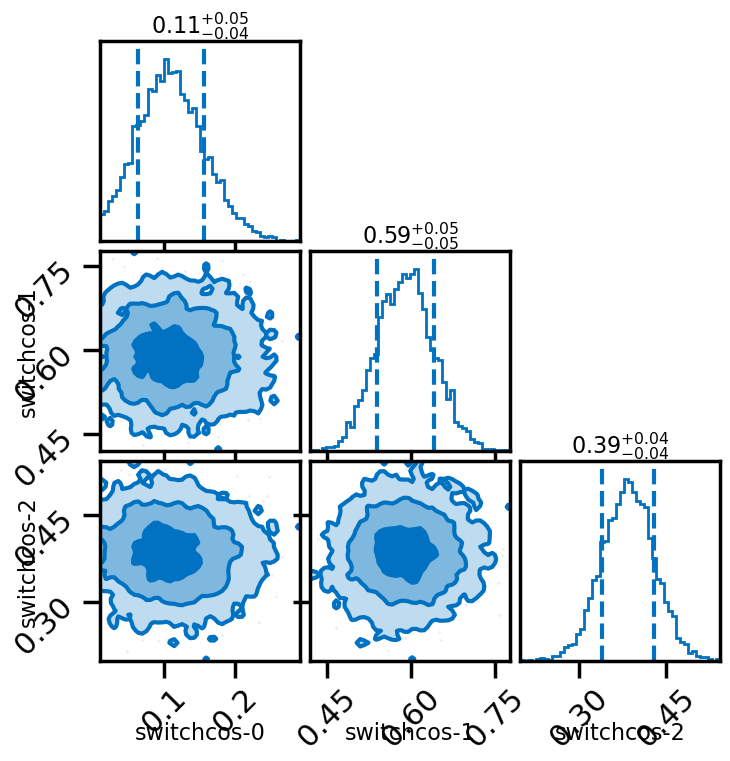

In [13]:
# Posterior of the mixing parameters.
result.plot_corner()

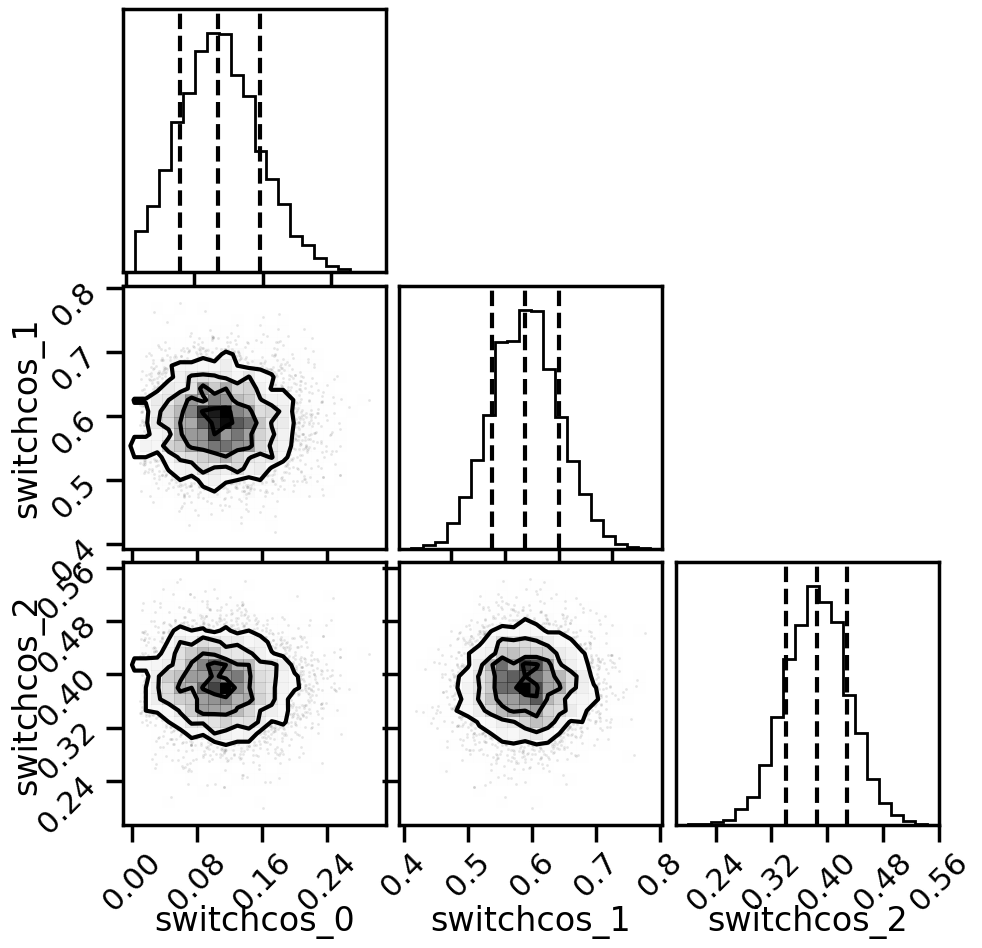

In [14]:
#corner plots
import corner
fig, axs = plt.subplots(3,3, figsize=(10,10), dpi=100)
corner.corner(mix_model.posterior,labels=['switchcos_0','switchcos_1', 'switchcos_2'],quantiles=[0.16, 0.5, 0.84],fig=fig)
plt.show()


## 4. Predictions

In [15]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(plot_g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(plot_g, CI=[5,20,80,95])

(10000, 3)
using provided samples instead of posterior


In [16]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [17]:
# Map value prediction for the step mixing function parameter
map_prediction = mix_model.evaluate(mix_model.map, plot_g)

In [18]:
_,_,CI_weights,_=mix_model.predict_weights(plot_g, CI=[5,20, 80, 95])
perw_5, perw_20, perw_80, perw_95 = CI_weights

(5020, 100)


In [19]:
prior_sample = np.array(list(priors.sample(5000).values())).T
_,_,CI_prior_weights,_=mix_model.predict_weights(plot_g, CI=[5,20, 80, 95], samples=prior_sample)
priorw_5, priorw_20, priorw_80, priorw_95 = CI_prior_weights

using provided samples instead of posterior
(5000, 100)


Text(0, 0.5, 'w')

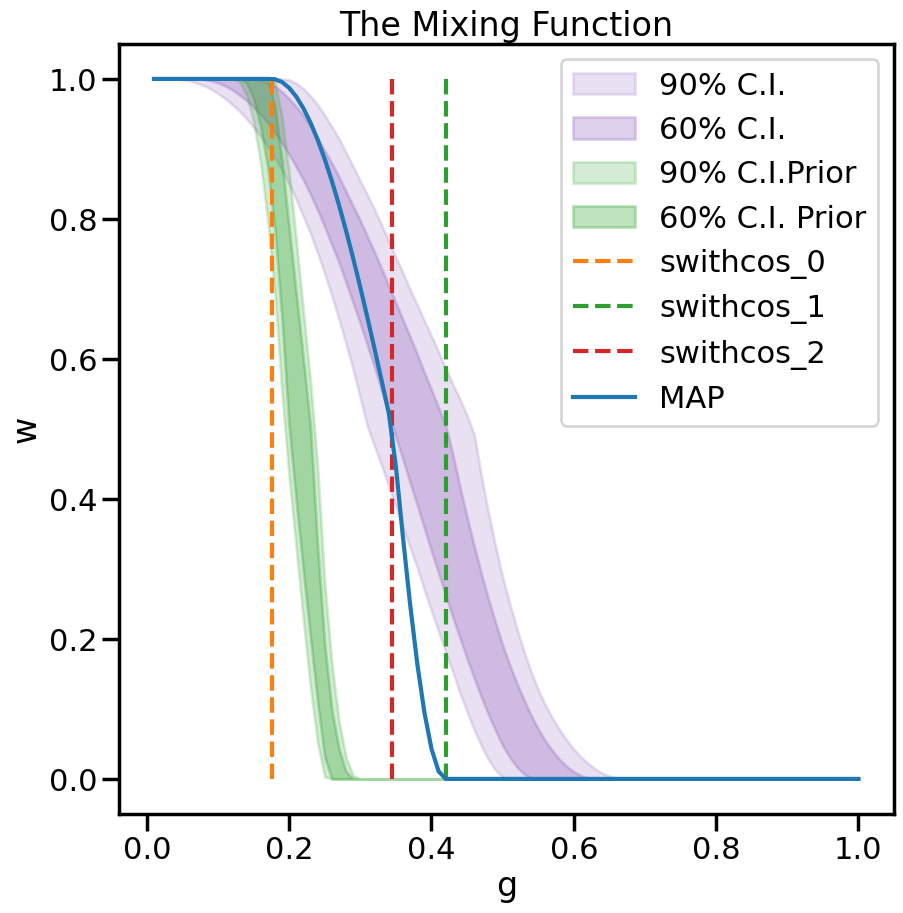

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.fill_between(plot_g,perw_5,perw_95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,perw_20,perw_80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')

ax.fill_between(plot_g,priorw_5,priorw_95,color=sns.color_palette()[2], alpha=0.2, label='90% C.I.Prior')
ax.fill_between(plot_g,priorw_20,priorw_80, color=sns.color_palette()[2], alpha=0.3, label='60% C.I. Prior')


w,_= mix_model.evaluate_weights(mix_model.map,plot_g)
ax.vlines(mix_model.map[0],0,1, linestyle='--', color=sns.color_palette()[1], label='swithcos_0')
ax.vlines(mix_model.map[1],0,1, linestyle='--', color=sns.color_palette()[2], label='swithcos_1')
ax.vlines(mix_model.map[2],0,1, linestyle='--', color=sns.color_palette()[3], label='swithcos_2')
ax.plot(plot_g, w, label='MAP')
ax.legend()
ax.set_title('The Mixing Function')
ax.set_xlabel('g')
ax.set_ylabel('w')

Text(0.5, 0, 'g')

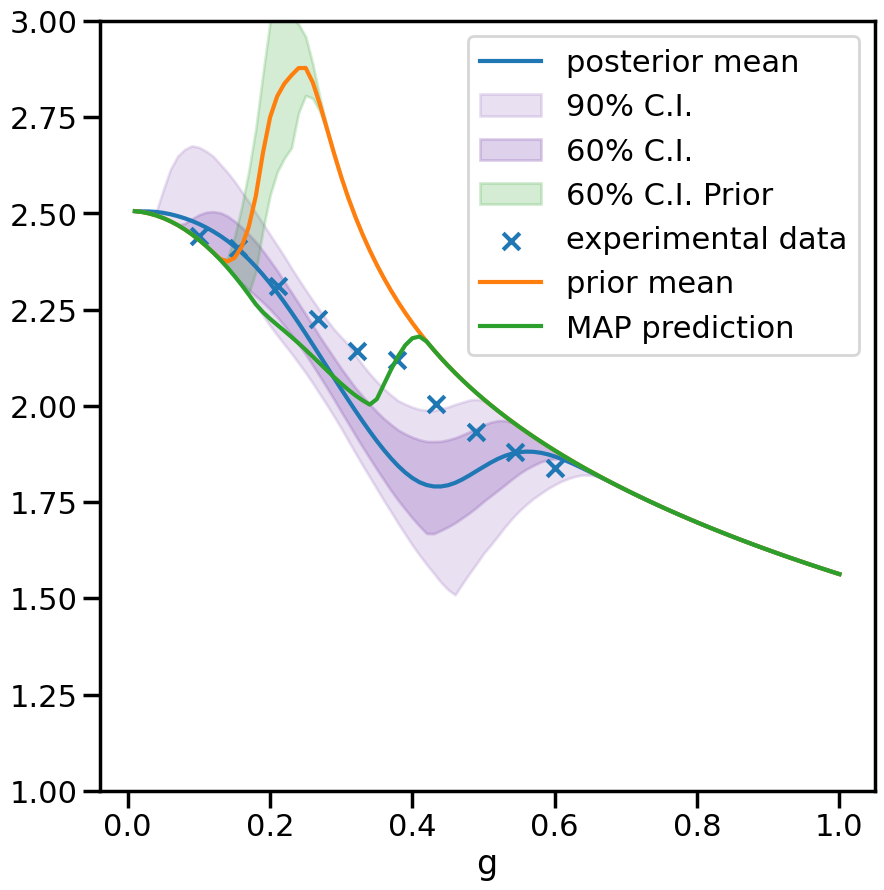

In [21]:
%matplotlib inline
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(plot_g, mean.flatten(), label='posterior mean')
ax.fill_between(plot_g,per5.flatten(),per95.flatten(),color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20.flatten(),per80.flatten(), color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.fill_between(plot_g,prior20.flatten(),prior80.flatten(),color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
ax.scatter(g,exp_data[0], marker='x', label='experimental data')
ax.plot(plot_g, mean_prior.flatten(), label='prior mean')
ax.plot(plot_g, map_prediction.flatten(), label='MAP prediction')
ax.set_ybound(1,3)
ax.legend()
ax.set_xlabel('g')